## python-rdm

The [python-rdm](https://pypi.org/project/python-rdm/) package is a collection of wrappers for relational data mining algorithms that aims to make them easily accessible. The input to the algorithms can be read from a relational database (MySQL, PostgreSQL, and SQLite are supported) or from plain CSV text files (with two additional header rows). 

`python-rdm` implements wrappers for several algorithms which have different software requirements. Algorithms such as Aleph and RSD require Prolog while algorithms such as TreeLiker and Caraf require Java. 

- In the first part of this notebook we demonstrate TreeLiker. This requires JRE (Java runtime environment) which is already available by default on most systems. If you do not have Java installed, please download it from the [official download page](https://www.java.com/en/download/). 
- In the [second part](#second_part) of this notebook we demonstrate RSD, which requires YAP prolog.

First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install python-rdm==0.3.6

Next, we check if `java` command can be invoked and stop the execution otherwise.

In [2]:
import subprocess as sp

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

try:
    proc = sp.run(['java', '-version'], stdout=sp.PIPE, stderr=sp.STDOUT)
    print(proc.stdout.decode('utf-8'))
except:
    print('ERROR: Java is not installed or not in PATH. Please download it from https://www.java.com/en/download/')
    raise StopExecution

java version "12.0.2" 2019-07-16
Java(TM) SE Runtime Environment (build 12.0.2+10)
Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)



We demonstrate the `python-rdm` by connecting to a remote relational database, reading data, running a selected relational data mining algorithm and presenting the results. We start by importing the relevant parts of `python-rdm` and establishing a connection to a remote MySQL database where a copy of the Michalski's East-West trains challenge dataset is stored. Keep in mind that in order for this remote connection to work the port 3306 must be open as it is used by MySQL for communication.

In [3]:
from rdm.db import DBContext, DBVendor, DBConnection
connection = DBConnection(
    'guest',                  # User
    'relational',             # Password
    'relational.fit.cvut.cz', # Host
    'trains',                 # Database
    vendor=DBVendor.MySQL     # Database type
)

The next step is to define the learning context. The target table is _trains_ and the target attribute is _direction_.

In [5]:
context = DBContext(connection, 
                    target_table='trains',
                    target_att='direction')

`DBContext` reads the data, parses column types, foreign keys etc. and loads the data into the `Orange.data.Table` object, stored in memory. Attributes such as `id` are stored as meta attributes. We print out all tables, their domains and first 5 instances.

In [6]:
for table in context.tables:
    print('Table: "{}"'.format(table))
    print('Domain: {}'.format(context.orng_tables[table].domain))
    print(context.orng_tables[table][:5])
    print('')

Table: "cars"
Domain: [position, shape, len, sides, roof, wheels, load_shape, load_num] {id, tid}
[[1, rectangle, short, not_double, none, 2, circle, 1] {1, 1},
 [2, rectangle, long, not_double, none, 3, hexagon, 1] {2, 1},
 [3, rectangle, short, not_double, peaked, 2, triangle, 1] {3, 1},
 [4, rectangle, long, not_double, none, 2, rectangle, 3] {4, 1},
 [1, rectangle, short, not_double, flat, 2, circle, 2] {5, 2}]

Table: "trains"
Domain: [ | direction] {id}
[[ | east] {1},
 [ | east] {2},
 [ | east] {3},
 [ | east] {4},
 [ | east] {5}]



We can now run the TreeLiker software. TreeLiker is a collection of fast algorithms for working with complex structured data in relational form. It contains implementations of three algorithms: RelF [[1]](#fn1), Poly [[2]](#fn1), and HiFi [[3]](#fn3). 

First, we create a TreeLikerConverter which transforms the data into a form appropriate for TreeLiker. Then, the selected algorithm is prepared to be run by providing a dataset and the default template. TreeLiker requires templates which provide means for syntactically constraining the sets of possible features (see the [manual](http://ida.felk.cvut.cz/treeliker/download/treeliker.pdf)). The TreeLiker wrapper in `python-rdm` provides a default template wrapper in order to minimize user burden. The following snippet creates the converter, the TreeLiker wrapper and shows the default template and the input data (facts) for the first data instance.

In [7]:
from rdm.db.converters import TreeLikerConverter
from rdm.wrappers import TreeLiker
from pprint import pprint

conv = TreeLikerConverter(context)
treeliker = TreeLiker(conv.dataset(), conv.default_template())
print('Feature template')
pprint(format(treeliker.template))
print('Data instance 0')
pprint(conv.dataset().split('\n')[0])

Feature template
('[has_cars(-cars), has_position(+cars, #position), has_shape(+cars, #shape), '
 'has_len(+cars, #len), has_sides(+cars, #sides), has_roof(+cars, #roof), '
 'has_wheels(+cars, #wheels), has_load_shape(+cars, #load_shape), '
 'has_load_num(+cars, #load_num)]')
Data instance 0
("east has_cars(cars1), has_position(cars1, '1'), has_shape(cars1, "
 "'rectangle'), has_len(cars1, 'short'), has_sides(cars1, 'not_double'), "
 "has_roof(cars1, 'none'), has_wheels(cars1, '2'), has_load_shape(cars1, "
 "'circle'), has_load_num(cars1, '1'), has_cars(cars2), has_position(cars2, "
 "'2'), has_shape(cars2, 'rectangle'), has_len(cars2, 'long'), "
 "has_sides(cars2, 'not_double'), has_roof(cars2, 'none'), has_wheels(cars2, "
 "'3'), has_load_shape(cars2, 'hexagon'), has_load_num(cars2, '1'), "
 "has_cars(cars3), has_position(cars3, '3'), has_shape(cars3, 'rectangle'), "
 "has_len(cars3, 'short'), has_sides(cars3, 'not_double'), has_roof(cars3, "
 "'peaked'), has_wheels(cars3, '2'), has_

We run TreeLiker to obtain the data in ARFF format which can be loaded into the `Table` data structure of the Orange data mining suite (`Table` is a wrapper around Numpy arrays and can be used with `scikit-learn` data mining library). We print the shape of the data and the first 20 features.

In [8]:
from rdm.helpers import arff_to_orange_table

treeliker_arff, _ = treeliker.run()
table = arff_to_orange_table(treeliker_arff)
print(table.X.shape)
print(table.Y.shape)
for attr in table.domain[:20]:
    print(attr.name)

(20, 175)
(20,)
has_cars(A), has_len(A, \'long\')
has_cars(A), has_len(A, \'long\'), has_load_num(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_load_num(A, \'1\'), has_position(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_load_num(A, \'1\'), has_position(A, \'2\')
has_cars(A), has_len(A, \'long\'), has_load_shape(A, \'circle\')
has_cars(A), has_len(A, \'long\'), has_position(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_position(A, \'2\')
has_cars(A), has_len(A, \'long\'), has_roof(A, \'flat\')
has_cars(A), has_len(A, \'long\'), has_roof(A, \'flat\'), has_position(A, \'2\')
has_cars(A), has_len(A, \'long\'), has_roof(A, \'none\')
has_cars(A), has_len(A, \'long\'), has_roof(A, \'none\'), has_position(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_wheels(A, \'2\')
has_cars(A), has_len(A, \'long\'), has_wheels(A, \'2\'), has_load_num(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_wheels(A, \'2\'), has_position(A, \'1\')
has_cars(A), has_len(A, \'long\'), has_wheels(A, \'2\')

Finally, we select 20 best features and build and visualize a simple decision tree. The Recursive-Filter Elimination (RFE) method is used with a linear SVM as the estimator. Because this example is only a demonstration of `python-rdm` no evaluation is performed.

In [9]:
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

estimator = SVC(kernel='linear')
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(table.X, table.Y)
X1 = table.X[:,selector.support_]

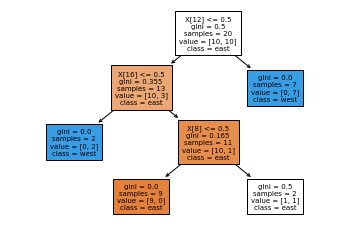

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
tree = DecisionTreeClassifier(min_samples_leaf=2)
tree.fit(X1, table.Y)
y_names = np.array([x.name for x in table.domain.attributes])[selector.support_]
_=plot_tree(tree, 
            #feature_names=y_names, # long names will mess up the picture!
            filled=True, 
            fontsize=7, 
            class_names=[table.domain.class_var.str_val(i) for i in [0,1]],
            label='all')

Feature names are very long so we need to print the tree in textual form to get the complete information.

In [11]:
from sklearn.tree import export_text
names = list(np.array([x.name for x in table.domain.attributes])[selector.support_])
tree_rules = export_text(tree, feature_names=names)
print(tree_rules)
for i,val in enumerate(table.domain.class_var.values):
    print('class {}: {}'.format(i, val))

|--- has_cars(A), has_position(A, \'3\'), has_load_num(A, \'1\') <= 0.50
|   |--- has_cars(A), has_sides(A, \'double\'), has_load_shape(A, \'circle\') <= 0.50
|   |   |--- class: 1.0
|   |--- has_cars(A), has_sides(A, \'double\'), has_load_shape(A, \'circle\') >  0.50
|   |   |--- has_cars(A), has_load_shape(A, \'triangle\'), has_load_num(A, \'1\') <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- has_cars(A), has_load_shape(A, \'triangle\'), has_load_num(A, \'1\') >  0.50
|   |   |   |--- class: 0.0
|--- has_cars(A), has_position(A, \'3\'), has_load_num(A, \'1\') >  0.50
|   |--- class: 1.0

class 0: east
class 1: west


---

<a id='second_part'></a>
### RSD 


In this part of the notebook we demonstrate the RSD algorithm [[4]](#fn4). As many other relational data mining algorithms RSD requires Prolog. Specifically, [YAP Prolog version 6.3.3](https://github.com/xflows/rdm/blob/master/yap-6.3.3/yap-6.3.3.zip) is known to work; other version may or may not work due to internal changes in YAP. Please consult the official [installation instructions of YAP 6.3.3](https://github.com/vscosta/yap-6.3/tree/yap-6.3.3) about how to install YAP on your system. Compilers such as gcc and lcc on Linux, cc on Solaris and Visual C++ 6.0 on Windows are known to compile YAP.

First of all, we check whether the `yap` executable is available.

In [12]:
try:
    proc = sp.run(['yap', '-?'], stdout=sp.PIPE, stderr=sp.STDOUT)
    print(proc.stdout.decode('utf-8'))
except:
    print('ERROR: YAP Prolog is not installed or not in PATH. Please download and install it from https://github.com/xflows/rdm/blob/master/yap-6.3.3/yap-6.3.3.zip')
    raise StopExecution


[ Valid switches for command line arguments: ]
  -?   Shows this screen
  -b   Boot file 
  -dump-runtime-variables
  -f   initialization file or "none"
  -g   Run Goal Before Top-Level 
  -z   Run Goal Before Top-Level 
  -q   start with informational messages off
  -l   load Prolog file
  -L   run Prolog file and exit
  -p   extra path for file-search-path
  -hSize   Heap area in Kbytes (default: 8000, minimum: 8000)
  -sSize   Stack area in Kbytes (default: 2400, minimum: 2400)
  -tSize   Trail area in Kbytes (default: 384, minimum: 384)
  -GSize  Max Area for Global Stack
  -LSize   Max Area for Local Stack (number must follow L)
  -TSize   Max Area for Trail (number must follow L)
  -nosignals   disable signal handling from Prolog

[Execution Modes]
  -J0  Interpreted mode (default)
  -J1  Mixed mode only for user predicates
  -J2  Mixed mode for all predicates
  -J3  Compile all user predicates
  -J4  Compile all predicates
  -ts  Maximum table space area in Mbytes (default: unl

To demonstrate RSD we use the Mutagenesis dataset which consists of 230 molecules trialed for mutagenicity on Salmonella typhimurium. There are three tables: `atom`, `bond` and `molecule`. The data is read from a remote MySQL database.

In [13]:
from rdm.db import DBContext, DBVendor, DBConnection
connection = DBConnection(
    'guest',                  # User
    'relational',             # Password
    'relational.fit.cvut.cz', # Host
    'mutagenesis',            # Database
    vendor=DBVendor.MySQL     # Database type
)
context = DBContext(connection, 
                    target_table='molecule',
                    target_att='mutagenic')

In order to use RSD on the mutagenesis data we have to discretize continuous attributes to prevent RSD from using single values. We employ equal frequency discretization into 3 intervals which is available in the Orange data mining suite.

In [15]:
import Orange
from collections import defaultdict
from rdm.db.converters import OrangeConverter

conv = OrangeConverter(context)
disc = Orange.preprocess.Discretize()
disc.method = Orange.preprocess.discretize.EqualFreq(n=3)

target_d = disc(conv.target_Orange_table())
other_d = []
for table in conv.other_Orange_tables():
    other_d.append(disc(table))

discretization_intervals = defaultdict(dict)
for table in [target_d] + other_d:
    for attr in table.domain.attributes:
        if attr.compute_value is not None:
            discretization_intervals[table.name][attr.name] = attr.compute_value.points
discretization_intervals

defaultdict(dict,
            {'molecule': {'logp': [2.7, 4.25], 'lumo': [-1.9035, -1.4455]},
             'atom': {'charge': [-0.1155, 0.1205]}})

Let's run the RSD learner. First, we create an `RSDConverter` instance which transforms the data into a form appropriate for RSD (Prolog clauses) while taking into account the computed discretization intervals. RSD supports the following parameters which control feature construction process:

- clauselength
- depth
- negation
- min_coverage
- filtering

We set the maximum length of a feature body to 4, run RSD and display first 10 induced features.

In [16]:
from rdm.db.converters import RSDConverter
from rdm.wrappers import RSD

conv = RSDConverter(context, discr_intervals=discretization_intervals)
rsd = RSD()
rsd.set('clauselength', 4)

features, arff, _ = rsd.induce(conv.background_knowledge(),
                                   examples=conv.all_examples(),
                                   cn2sd=False)
feature_names = [fn.strip() for fn in features.split('\n') if fn.strip()]
pprint(feature_names[:10])

['f(1,A):-molecule_has_atom(A,B),atom_has_bond(B,C),bond_type(C,2).',
 'f(2,A):-molecule_has_atom(A,B),atom_element(B,f).',
 'f(3,A):-molecule_has_atom(A,B),atom_element(B,b).',
 'f(4,A):-molecule_has_atom(A,B),atom_element(B,i).',
 'f(5,A):-molecule_has_atom(A,B),atom_type(B,27).',
 'f(6,A):-molecule_has_atom(A,B),atom_type(B,21).',
 'f(7,A):-molecule_has_atom(A,B),atom_type(B,26).',
 'f(8,A):-molecule_has_atom(A,B),atom_type(B,22).',
 'f(9,A):-molecule_has_atom(A,B),atom_type(B,35).',
 'f(10,A):-molecule_has_atom(A,B),atom_type(B,10).']


The resulting data in ARFF format can be loaded into `Orange.Table`. However, the ARFF produced by RSD uses short feature names like `f1`, `f2`, etc., so we need to rename the features in order to preserve information.

In [17]:
table = arff_to_orange_table(arff)
new_classvar = table.domain.class_var.renamed('mutagenic')
new_attributes = [var.renamed(feature_names[i]) for i,var in enumerate(table.domain.attributes)]
new_domain = Orange.data.Domain(new_attributes, class_vars=[new_classvar])
table = Orange.data.Table.from_table(new_domain, table)

Using the newly constructed `Table` we split the data into train (75%) and test (25%) set and build and evaluate the decision tree.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(table.X, table.Y, test_size=0.25, stratify=table.Y, random_state=42)

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(metrics.classification_report(y_test, tree.predict(X_test), target_names=table.domain.class_var.values))

              precision    recall  f1-score   support

          no       0.93      0.88      0.90        16
         yes       0.94      0.97      0.95        31

    accuracy                           0.94        47
   macro avg       0.94      0.92      0.93        47
weighted avg       0.94      0.94      0.94        47



Finally, let's print 5 most important features according to our decision tree.

In [19]:
for idx in (-tree.feature_importances_).argsort()[:5]:
    print(feature_names[idx])

f(33,A):-molecule_ind1(A,0).
f(39,A):-molecule_lumo(A,'=< -1.90').
f(16,A):-molecule_has_atom(A,B),atom_type(B,14).
f(41,A):-molecule_lumo(A,'> -1.45').
f(11,A):-molecule_has_atom(A,B),atom_type(B,29).


---
### References

<span id="fn1"> [1] Ondřej Kuželka and Filip Železný. Block-Wise Construction of Tree-like Relational Features with Monotone Reducibility and Redundancy. Machine Learning, 83, 2011. </span>

<span id="fn2"> [2] Ondřej Kuželka, Andrea Szabóová, Matěj Holec and Filip Železný. Gaussian Logic for Predictive Classification. ECML/PKDD 2011: European Conference on Machine Learning and Principles and Practice of Knowledge Discovery in Databases (this paper described a restricted version of Poly) </span>

<span id="fn3"> [3] Ondřej Kuželka and Filip Železný. HiFi: Tractable Propositionalization through Hierarchical Feature Construction. Late Breaking Papers, the 18th International Conference on Inductive Logic Programming, 2008. </span>

<span id="fn4"> [4] Železny F., Lavrač N.: Propositionalization-Based Relational Subgroup Discovery with RSD.
Machine Learning 62(1-2): 33-63, 2006. </span>